引入套件

In [1]:
# !which python
# !python --version
# !pip list | grep pandas

In [2]:
import cn2an
print("cn2an 安裝成功！")

cn2an 安裝成功！


In [3]:
# 會用到的套件
import pandas as pd
import jieba
import jieba.analyse
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import cn2an

繪圖相關設定

In [4]:
from matplotlib import font_manager
# 設定圖的字體大小
plt.rcParams['font.size'] = 14

# 設定圖的中文字體 
#plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] # Windows 中文字體
plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms'] # MacOS 內建中文字體

# 設定文字雲中文字體路徑
fontPath = 'raw_data/SourceHanSansTW-Regular.otf' # 設定字型
fprop = font_manager.FontProperties(fname=fontPath)  # 載入字型

### 資料介紹
資料來源：
+ TarFlow 蒐集PTT 房屋版 文章
+ 關鍵字：房價
+ 時間： 2024-03-01 ~ 2025-3-01
+ 資料筆數：共 5195 篇文章

讀取ptt檔案ptt_house_price.csv

In [5]:
df = pd.read_csv('/home/peizn/社媒/hw1/raw_data/ptt_house_price.csv')
df.head()

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,jump0517,home_sale,連結：\nhttps://money.udn.com/money/story/5621/78...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""fatpigbgman""...",1.168.65.178,2024-03-02 01:42:37,ptt
1,2,https://www.ptt.cc/bbs/home-sale/M.1709251729....,[情報]好房網2月房價,2024-03-01 08:08:47,linlinme5208,home_sale,好房網 重點縣市成交漲跌排行\nhttps://price.housefun.com.tw/...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""ChennBZ"", ""c...",211.20.144.117,2024-03-02 01:42:37,ptt
2,3,https://www.ptt.cc/bbs/home-sale/M.1709255830....,Re:[情報]好房網2月房價,2024-03-01 09:17:08,junior020486,home_sale,你們那個要買新竹熱區的手腳要快\n新竹現在很誇張\n外圍補漲的很兇\n前幾天星XX超開價成交...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""hellogym"", ""...",49.216.24.218,2024-03-02 01:42:37,ptt
3,4,https://www.ptt.cc/bbs/home-sale/M.1709260904....,[閒聊]基隆是台北之外最不可能蓋GG的嗎,2024-03-01 10:41:42,Austenite,home_sale,最近各縣市都被點名要蓋GG\n高雄 台中 嘉義 虎尾\n被點名出列的房價都開始漲\n\n基隆...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""wwrest"", ""cm...",1.163.246.7,2024-03-02 01:42:37,ptt
4,5,https://www.ptt.cc/bbs/home-sale/M.1709263369....,[請益]預售屋可否負擔,2024-03-01 11:22:47,mosfets,home_sale,各位前輩好\n\n小弟目前在竹科工作 覺得新竹房價越來越高 因為工作快三年 有些自備款 有想...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""JohnLackey"",...",39.9.32.99,2024-03-02 01:42:37,ptt


### 資料初步清理
- 清除內文為空值的文章

- 透過觀察發現ptt的文章常用兩個換行符號作為句子的結尾，因此將兩個換行取代為句號。

- 清除不重要的字如換行、網址

In [6]:
clear_df = df.copy()

#去除本次不會用到的欄位
drop_cols = ['system_id', 'artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource'] # 保留'artUrl'
clear_df.drop(drop_cols, axis = 1, inplace = True) # 若inplace=False會回傳新的Dataframe，需要賦值接它

#去除文章內容為空值的筆數
clear_df.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)

#新增['sentence']欄位，用'。'取代'\n\n'，並移除'\n'
clear_df['sentence'] = clear_df['artContent'].str.replace(r'\n\n','。', regex=True)
clear_df['sentence'] = clear_df['sentence'].str.replace(r'\n','，', regex=True)

#移除內文中的網址
clear_df['sentence'] = clear_df['sentence'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

clear_df.head(10)

,artUrl,artTitle,artDate,artContent,sentence
0,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,連結：， 駁斥養地炒房說。媒體報導，具公股色彩的台灣金聯近年大舉在南台灣與建商競標土地，得標...
1,https://www.ptt.cc/bbs/home-sale/M.1709251729....,[情報]好房網2月房價,2024-03-01 08:08:47,好房網 重點縣市成交漲跌排行\nhttps://price.housefun.com.tw/...,好房網 重點縣市成交漲跌排行， ->區域實價登錄趨勢。2024年。2月，重點縣市實價登錄漲跌...
2,https://www.ptt.cc/bbs/home-sale/M.1709255830....,Re:[情報]好房網2月房價,2024-03-01 09:17:08,你們那個要買新竹熱區的手腳要快\n新竹現在很誇張\n外圍補漲的很兇\n前幾天星XX超開價成交...,你們那個要買新竹熱區的手腳要快，新竹現在很誇張，外圍補漲的很兇，前幾天星XX超開價成交後，環...
3,https://www.ptt.cc/bbs/home-sale/M.1709260904....,[閒聊]基隆是台北之外最不可能蓋GG的嗎,2024-03-01 10:41:42,最近各縣市都被點名要蓋GG\n高雄 台中 嘉義 虎尾\n被點名出列的房價都開始漲\n\n基隆...,最近各縣市都被點名要蓋GG，高雄 台中 嘉義 虎尾，被點名出列的房價都開始漲。基隆484永遠...
4,https://www.ptt.cc/bbs/home-sale/M.1709263369....,[請益]預售屋可否負擔,2024-03-01 11:22:47,各位前輩好\n\n小弟目前在竹科工作 覺得新竹房價越來越高 因為工作快三年 有些自備款 有想...,各位前輩好。小弟目前在竹科工作 覺得新竹房價越來越高 因為工作快三年 有些自備款 有想先上車...
5,https://www.ptt.cc/bbs/home-sale/M.1709265008....,[請益]建議用二胎房貸嗎？,2024-03-01 11:50:06,是這樣的，我目前的房屋是在三年前買的\n\n使用 40 年房貸 / 寬限期 5 年\n\n目...,是這樣的，我目前的房屋是在三年前買的。使用 40 年房貸 / 寬限期 5 年。目前還在寬限期...
6,https://www.ptt.cc/bbs/home-sale/M.1709265534....,[新聞]小坪數買氣夯？全台「小宅」驚人空屋率曝,2024-03-01 11:58:52,小坪數買氣夯？全台「小宅」驚人空屋率曝光\n\nTVBS 記者 陳文越 / 攝影 鍾德榮 報...,小坪數買氣夯？全台「小宅」驚人空屋率曝光。TVBS 記者 陳文越 / 攝影 鍾德榮 報導。房...
7,https://www.ptt.cc/bbs/home-sale/M.1709267197....,[請益]掛4買第三間是否可行,2024-03-01 12:26:34,各位前輩好\n\n小弟目前在高雄工作 覺得高雄房價越來越高\n且這一波預售都還在漲，之後想必...,各位前輩好。小弟目前在高雄工作 覺得高雄房價越來越高，且這一波預售都還在漲，之後想必會把中古...
8,https://www.ptt.cc/bbs/home-sale/M.1709272677....,[新聞]月收72K想買988萬新成屋 過來人警1事：,2024-03-01 13:57:55,連結：\nhttps://bit.ly/49Ts3Zn\n內文：月收72K想買988萬新成屋...,連結：， 過來人警1事：房貸比房東無情。在眾多台灣年輕人面臨的生活議題中，「是否應該購房」一...
9,https://www.ptt.cc/bbs/home-sale/M.1709281716....,[請益]政府機關大樓對週邊房市的影響,2024-03-01 16:28:34,https://news.ltn.com.tw/amp/news/life/breaking...,from MeowPtt on my iPhone。


### 斷句
中文主要以標點符號進行斷句，並清除空的字串

In [7]:
clear_df['sentence'] = clear_df['sentence'].str.split("[,，。！!？?]{1,}")

sent_df = clear_df.explode('sentence').reset_index(drop=True)

sent_df.head(10)

,artUrl,artTitle,artDate,artContent,sentence
0,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,連結：
1,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,駁斥養地炒房說
2,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,媒體報導
3,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,具公股色彩的台灣金聯近年大舉在南台灣與建商競標土地
4,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,得標後不開發
5,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,養
6,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,放數年再加價轉售給建商賺價差
7,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,台灣金聯今天澄清
8,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,絕不炒作房價也未曾炒作土地
9,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,土


### 斷詞
斷詞引擎設定：使用 Jieba 當作斷詞系統。

In [8]:
# 初始化斷詞引擎：不一定要設定，只使用內建效果也可以
# 參考網址：https://raw.githubusercontent.com/ldkrsi/jieba-zh_TW/master/jieba/dict.txt
jieba.set_dictionary('dict/dict.txt')

斷詞前先將標點符號清除，並使用正規表達式清除空字串

In [9]:
#去除句子中除了字母、數字、空白字符以外的符號
sent_df['sentence'] = sent_df['sentence'].str.replace(r'[^\w\s]+', '', regex=True).astype(str)

# 把長度小於1的sentence刪掉
sent_df = sent_df[sent_df["sentence"].str.len() > 1]

sent_df.head(10)

,artUrl,artTitle,artDate,artContent,sentence
0,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,連結
1,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,駁斥養地炒房說
2,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,媒體報導
3,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,具公股色彩的台灣金聯近年大舉在南台灣與建商競標土地
4,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,得標後不開發
6,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,放數年再加價轉售給建商賺價差
7,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,台灣金聯今天澄清
8,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,絕不炒作房價也未曾炒作土地
10,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,地未運用是前期作業尚未完成
11,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,並非養地


使用jieba進行斷詞

In [10]:
word_df = sent_df.assign(word = sent_df['sentence'].apply(jieba.lcut)).explode('word').drop(['sentence'], axis=1)

# 去除空值
word_df = word_df.dropna(subset=['word'])

word_df.head(10)

Building prefix dict from /home/peizn/社媒/hw1/dict/dict.txt ...
Loading model from cache /tmp/jieba.u3af32db59c95dbae1b15abfb010c2876.cache
Loading model cost 0.467 seconds.
Prefix dict has been built successfully.


,artUrl,artTitle,artDate,artContent,word
0,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,連結
1,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,
1,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,駁斥
1,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,養地
1,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,炒房
1,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,說
2,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,媒體
2,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,報導
3,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,具
3,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,公股


#### 為了進行前後比較，先透過繪製詞頻圖及文字雲觀察一下目前的資料。

### 計算去除停用字及更新字典前的詞頻

In [11]:
freq_df = pd.DataFrame(word_df['word'].value_counts()).sort_values(by = ['count'], ascending = False).reset_index()
freq_df.head(10)

,word,count
0,,47112
1,的,46265
2,是,16133
3,有,10437
4,了,9898
5,也,9777
6,都,9482
7,房價,9355
8,在,9087
9,就,8962


### 4.6 視覺化結果

matplotlib 畫圖中文顯示不出來的問題

* Mac : <a href="https://blog.csdn.net/RivenDong/article/details/118990773">參考方式</a>
* Windows : <a href="https://medium.com/marketingdatascience/%E8%A7%A3%E6%B1%BApython-3-matplotlib%E8%88%87seaborn%E8%A6%96%E8%A6%BA%E5%8C%96%E5%A5%97%E4%BB%B6%E4%B8%AD%E6%96%87%E9%A1%AF%E7%A4%BA%E5%95%8F%E9%A1%8C-f7b3773a889b">參考方式</a>
* 暫存查找 path 方式：matplotlib.get_cachedir()

#### 繪製詞頻為前10高的長條圖

In [12]:
import matplotlib.font_manager as fm

font_path = "/home/peizn/社媒/hw1/raw_data/NotoSansTC-Regular.ttf"
my_font = fm.FontProperties(fname=font_path)

# 手動將字體添加到 matplotlib 字體庫中
fm.fontManager.addfont(font_path)
# 設定 matplotlib 使用指定字體
plt.rcParams['font.family'] = my_font.get_name()

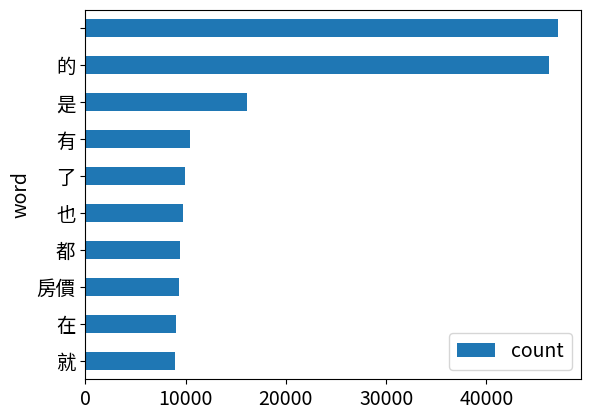

In [13]:
freq_df.head(10).plot.barh(x = 'word', y = 'count').invert_yaxis()
plt.show()

#### 繪製文字雲

In [14]:
# wordcloud的輸入須為dict，因此先將freq_df轉換成成dict
freq_dict = freq_df.set_index('word').to_dict()
freq_dict = freq_dict['count'] # 取得 count 對應的內部字典

print(dict(list(freq_dict.items())[:10]))

{' ': 47112, '的': 46265, '是': 16133, '有': 10437, '了': 9898, '也': 9777, '都': 9482, '房價': 9355, '在': 9087, '就': 8962}


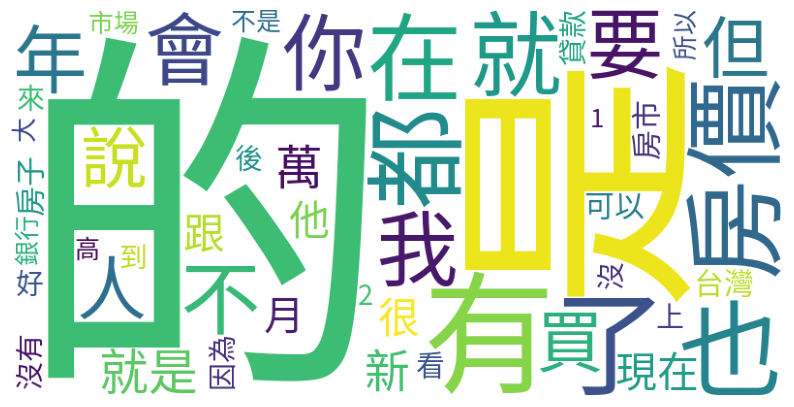

In [15]:
# 繪製文字雲
wordcloud = WordCloud(background_color = 'white', width = 800, height = 400, font_path = fontPath, max_words = 50)
wordcloud.generate_from_frequencies(freq_dict)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

發現斷詞有許多一個字的結果，這些字對後續分析沒有意義，因此先去除斷詞結果少於兩個字的資料。

In [16]:
#去除少於兩個字的詞語
word_df = word_df.loc[word_df['word'].str.len() > 1]

計算詞頻並繪製長條圖

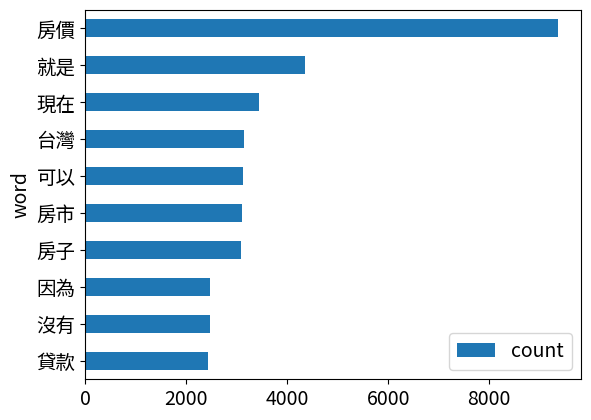

In [17]:
freq_df = pd.DataFrame(word_df['word'].value_counts()).sort_values(by = ['count'], ascending = False).reset_index()

freq_df.head(10).plot.barh(x = 'word', y = 'count').invert_yaxis()

plt.show()

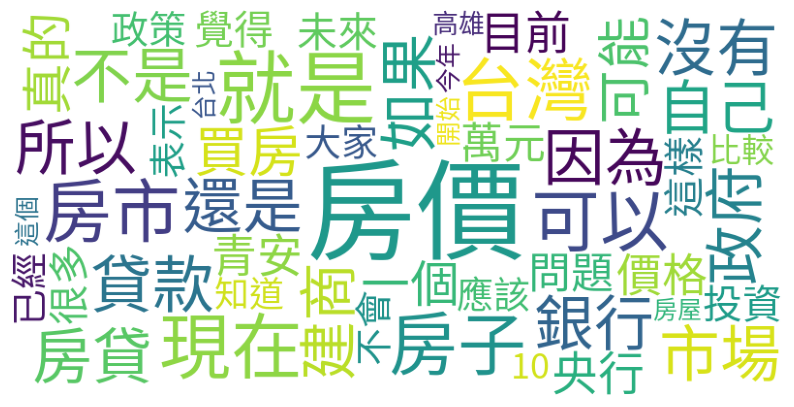

In [18]:
# wordcloud的輸入須為dict，因此先將freq_df轉換成dict
freq_dict = freq_df.set_index('word').to_dict()
freq_dict = freq_dict['count']

# 繪製文字雲
wordcloud_no1 = WordCloud(background_color = 'white', width = 800, height = 400, font_path = fontPath, max_words = 50)
wordcloud_no1.generate_from_frequencies(freq_dict)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud_no1)
plt.axis('off')
plt.show()

### 移除停用字

目前資料中還是有許多對後續分析沒有幫助的無意義詞彙(停用字)，接下來會清除這些停用字。

In [19]:
# 以檔案形式匯入通用的停用字檔案
# 將stopwords存成list
stopwords = [line.strip() for line in open('dict/stopwords.txt', 'r', encoding='utf-8').readlines()] 

移除word欄位中的停用字

In [20]:
noStop_df = word_df[~word_df['word'].isin(stopwords)]

noStop_df.head(10)

,artUrl,artTitle,artDate,artContent,word
0,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,連結
1,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,駁斥
1,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,養地
1,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,炒房
2,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,媒體
2,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,報導
3,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,公股
3,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,色彩
3,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,台灣
3,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,金聯


### 計算去除停用字後的詞頻

#### 再次繪製長條圖

/tmp/ipykernel_422312/583685406.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  freq_df_nostop = pd.DataFrame(pd.value_counts(noStop_df['word'])).sort_values(by = ['count'], ascending = False).reset_index()


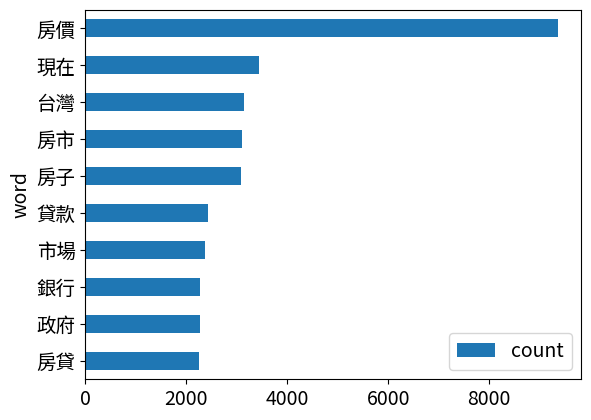

In [21]:
freq_df_nostop = pd.DataFrame(pd.value_counts(noStop_df['word'])).sort_values(by = ['count'], ascending = False).reset_index()

freq_df_nostop.head(10).plot.barh(x = 'word', y = 'count').invert_yaxis()
plt.show()

#### 再次繪製文字雲

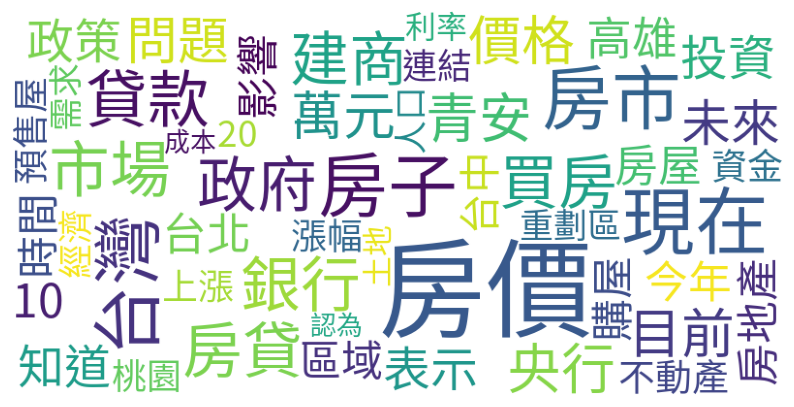

In [22]:
freq_dict_nostop = freq_df_nostop.set_index('word').to_dict()
freq_dict_nostop = freq_dict_nostop['count']

# 繪製文字雲
wordcloud_nostop = WordCloud(background_color = 'white', width = 800, height = 400, font_path = fontPath, max_words = 50)
wordcloud_nostop.generate_from_frequencies(freq_dict_nostop)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud_nostop)
plt.axis('off')
plt.show()

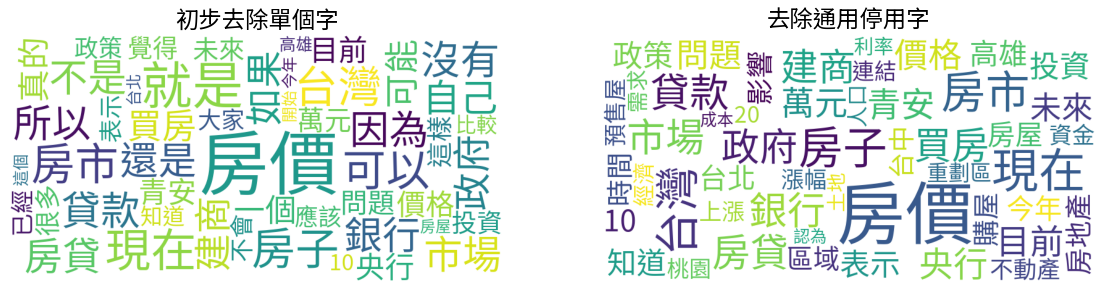

In [23]:
plt.figure(figsize = (14,8))

plt.subplot(1,2,1)
plt.imshow(wordcloud_no1)
plt.axis('off')
plt.title("初步去除單個字")

plt.subplot(1,2,2)
plt.imshow(wordcloud_nostop)
plt.axis('off')
plt.title("去除通用停用字")

plt.show()

比較原本的文字雲，可以發現像如果、不是、因為...這類的通用停用字已被去除，然而，還有些未存在通用停用字字典內且對後續分析沒有幫助的詞彙，因此以下將以手動方式來去除這些詞彙。

### 更新停用字字典
去除完通用停用字後，還是發現到有一些對文字雲分析較無幫助的詞彙，如:今年、現在、知道...
</br>我們將這些詞彙用手動的方式加入停用字字典，並比較去除後的結果。

In [24]:
# 手動加入停用字
stopwords_manual = ["今年", "去年", "近年", "數年", "每年", "半年", "連結", "現在", "目前", "認為", "持續", "一直", "時間", "這種", "表示", "看到", 
                    "知道", "字頭", "根本", "地方", "平均", "區域", "價格", "一堆", "指出", "直接", "萬坪"] 
stopwords.extend(stopwords_manual)

In [25]:
# 去除停用字
noStop_df_2 = noStop_df[~noStop_df['word'].isin(stopwords)]
noStop_df_2.head(10)

,artUrl,artTitle,artDate,artContent,word
1,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,駁斥
1,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,養地
1,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,炒房
2,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,媒體
2,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,報導
3,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,公股
3,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,色彩
3,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,台灣
3,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,金聯
3,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,台灣


#### 再次繪製文字雲

/tmp/ipykernel_422312/3623548723.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  freq_df_nostop_2 = pd.DataFrame(pd.value_counts(noStop_df_2['word'])).sort_values(by = ['count'], ascending = False).reset_index()


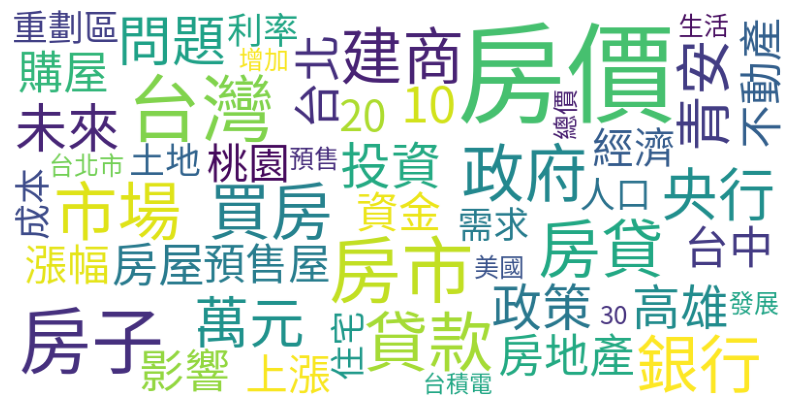

In [26]:
# 計算詞頻
freq_df_nostop_2 = pd.DataFrame(pd.value_counts(noStop_df_2['word'])).sort_values(by = ['count'], ascending = False).reset_index()

# wordcloud的輸入須為dict，因此先將freq_df轉換成成dict
freq_dict_nostop_2 = freq_df_nostop_2.set_index('word').to_dict()
freq_dict_nostop_2 = freq_dict_nostop_2['count']

# 繪製文字雲
wordcloud_nostop_2 = WordCloud(background_color = 'white', width = 800, height = 400, font_path = fontPath, max_words = 50)
wordcloud_nostop_2.generate_from_frequencies(freq_dict_nostop_2)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud_nostop_2)
plt.axis('off')
plt.show()

透過文字雲看一下目前為止做的文字處理結果有什麼差異

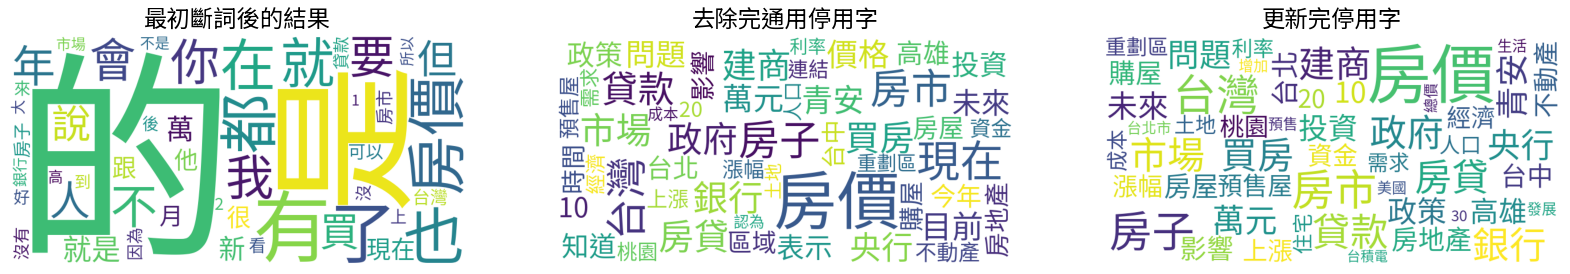

In [27]:
plt.figure(figsize = (20,14))

plt.subplot(1,3,1)
plt.imshow(wordcloud)
plt.axis('off')
plt.title("最初斷詞後的結果")

plt.subplot(1,3,2)
plt.imshow(wordcloud_nostop)
plt.axis('off')
plt.title("去除完通用停用字")

plt.subplot(1,3,3)
plt.imshow(wordcloud_nostop_2)
plt.axis('off')
plt.title("更新完停用字")

plt.show()

可以發現再進一步更新完停用字後，文字雲已正確去除我們手動加入的停用字，然而還存在一些組合字問題，如:萬元、年、坪...

### 更新斷詞字典

"萬元"、"年"、"坪"前面會有數字或文字，形成組合詞，如:30萬元、三十坪...

In [28]:
# 自動提取所有數字/文字 + 萬元 的詞並加入jieba斷詞字典
sent_df2 = sent_df.copy()

# 正則表達式匹配
pattern = r'([\d零一二三四五六七八九十百千萬億]+萬元)'
pattern2 = r'([\d零一二三四五六七八九十百]+年)'
pattern3 = r'([\d零一二三四五六七八九十百]+坪)'

# 找出所有符合條件的詞，並存入 set（除去重複詞）
# .sum() -> 把apply()的結果展開
custom_words = set(sent_df2["sentence"]
                   .apply(lambda x: re.findall(pattern, x))
                   .sum()).union(set(sent_df2["sentence"].apply(lambda x: re.findall(pattern2, x)).sum())).union(set(sent_df2["sentence"].apply(lambda x: re.findall(pattern3, x)).sum()))

# 存入斷詞字典
for word in custom_words:
    jieba.add_word(word)

重新進行斷詞及清除停用字

In [29]:
# sent_df是還沒斷詞過的df
word_df_updated = sent_df.assign(word = sent_df['sentence'].apply(jieba.lcut)).explode('word').drop(['sentence'], axis=1)

#把長度小於1的row刪掉
word_df_updated = word_df_updated.loc[word_df_updated['word'].str.len()>1]

#去除停用字
nostop_df_updated = word_df_updated[~word_df_updated['word'].isin(stopwords)]

nostop_df_updated.head()

,artUrl,artTitle,artDate,artContent,word
1,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,駁斥
1,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,養地
1,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,炒房
2,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,媒體
2,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,報導


檢查"萬元"的前面有沒有匹配到數字或文字

In [30]:
num_wanyuan = nostop_df_updated[nostop_df_updated["word"].str.contains("萬元", na=False)]
num_wanyuan.head()

,artUrl,artTitle,artDate,artContent,word
373,https://www.ptt.cc/bbs/home-sale/M.1709272677....,[新聞]月收72K想買988萬新成屋 過來人警1事：,2024-03-01 13:57:55,連結：\nhttps://bit.ly/49Ts3Zn\n內文：月收72K想買988萬新成屋...,百萬元
380,https://www.ptt.cc/bbs/home-sale/M.1709272677....,[新聞]月收72K想買988萬新成屋 過來人警1事：,2024-03-01 13:57:55,連結：\nhttps://bit.ly/49Ts3Zn\n內文：月收72K想買988萬新成屋...,百萬元
381,https://www.ptt.cc/bbs/home-sale/M.1709272677....,[新聞]月收72K想買988萬新成屋 過來人警1事：,2024-03-01 13:57:55,連結：\nhttps://bit.ly/49Ts3Zn\n內文：月收72K想買988萬新成屋...,4萬元
384,https://www.ptt.cc/bbs/home-sale/M.1709272677....,[新聞]月收72K想買988萬新成屋 過來人警1事：,2024-03-01 13:57:55,連結：\nhttps://bit.ly/49Ts3Zn\n內文：月收72K想買988萬新成屋...,50萬元
385,https://www.ptt.cc/bbs/home-sale/M.1709272677....,[新聞]月收72K想買988萬新成屋 過來人警1事：,2024-03-01 13:57:55,連結：\nhttps://bit.ly/49Ts3Zn\n內文：月收72K想買988萬新成屋...,988萬元


檢查"年"的前面有沒有匹配到數字或文字

In [31]:
num_year = nostop_df_updated[nostop_df_updated["word"].str.contains("年", na=False)]
num_year.head()

,artUrl,artTitle,artDate,artContent,word
44,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,3年
64,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,年度
85,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,14年
89,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,前幾年
95,https://www.ptt.cc/bbs/home-sale/M.1709251729....,[情報]好房網2月房價,2024-03-01 08:08:47,好房網 重點縣市成交漲跌排行\nhttps://price.housefun.com.tw/...,2024年


檢查"坪"的前面有沒有匹配到數字或文字

In [32]:
num_ground = nostop_df_updated[nostop_df_updated["word"].str.contains("坪", na=False)]
num_ground.head()

,artUrl,artTitle,artDate,artContent,word
38,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,176坪
39,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,85坪
41,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,261坪
149,https://www.ptt.cc/bbs/home-sale/M.1709255830....,Re:[情報]好房網2月房價,2024-03-01 09:17:08,你們那個要買新竹熱區的手腳要快\n新竹現在很誇張\n外圍補漲的很兇\n前幾天星XX超開價成交...,一坪
207,https://www.ptt.cc/bbs/home-sale/M.1709265534....,[新聞]小坪數買氣夯？全台「小宅」驚人空屋率曝,2024-03-01 11:58:52,小坪數買氣夯？全台「小宅」驚人空屋率曝光\n\nTVBS 記者 陳文越 / 攝影 鍾德榮 報...,坪數


數字格式統一：阿拉伯數字轉成中文數字

In [33]:
nostop_df_updated["word"] = nostop_df_updated["word"].apply(lambda x: cn2an.transform(x, "an2cn"))

# 檢查阿拉伯數字有無正確轉換成中文
nostop_df_updated[nostop_df_updated["word"].str.contains("坪", na=False)].head()

/home/peizn/.local/lib/python3.11/site-packages/cn2an/transform.py:103: UserWarning: 超出数据范围，最长支持 16 位
  warn(str(e))
/tmp/ipykernel_422312/1316863311.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nostop_df_updated["word"] = nostop_df_updated["word"].apply(lambda x: cn2an.transform(x, "an2cn"))


,artUrl,artTitle,artDate,artContent,word
38,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,一百七十六坪
39,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,八十五坪
41,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,二百六十一坪
149,https://www.ptt.cc/bbs/home-sale/M.1709255830....,Re:[情報]好房網2月房價,2024-03-01 09:17:08,你們那個要買新竹熱區的手腳要快\n新竹現在很誇張\n外圍補漲的很兇\n前幾天星XX超開價成交...,一坪
207,https://www.ptt.cc/bbs/home-sale/M.1709265534....,[新聞]小坪數買氣夯？全台「小宅」驚人空屋率曝,2024-03-01 11:58:52,小坪數買氣夯？全台「小宅」驚人空屋率曝光\n\nTVBS 記者 陳文越 / 攝影 鍾德榮 報...,坪數


#### 重新計算詞頻

In [34]:
freq_df_updated = pd.DataFrame(pd.value_counts(nostop_df_updated['word'])).sort_values(by = ['count'], ascending = False).reset_index()

freq_df_updated.head(10)

/tmp/ipykernel_422312/1450957720.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  freq_df_updated = pd.DataFrame(pd.value_counts(nostop_df_updated['word'])).sort_values(by = ['count'], ascending = False).reset_index()


,word,count
0,房價,9355
1,台灣,3147
2,房市,3100
3,房子,3092
4,貸款,2437
5,市場,2379
6,銀行,2274
7,政府,2268
8,房貸,2250
9,建商,2213


#### 重新繪製詞頻長條圖

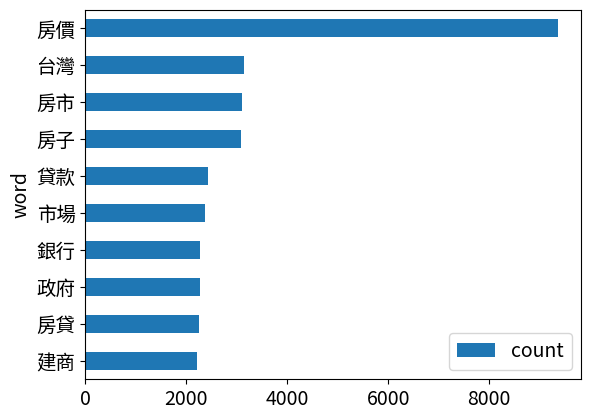

In [35]:
freq_df_updated.head(10).plot.barh(x='word', y='count').invert_yaxis()
plt.show()

#### 繪製文字雲

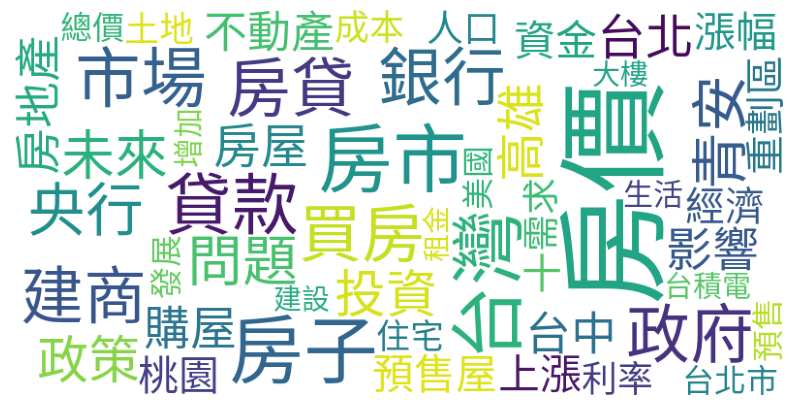

In [36]:
freq_dict_updated = freq_df_updated.set_index('word').to_dict()
freq_dict_updated = freq_dict_updated['count']

# 繪製文字雲
wordcloud_after = WordCloud(background_color='white', width=800, height = 400, font_path = fontPath, max_words = 50)
wordcloud_after.generate_from_frequencies(freq_dict_updated)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud_after)
plt.axis('off')
plt.show()

### 4.10 比較清理前後的文字雲

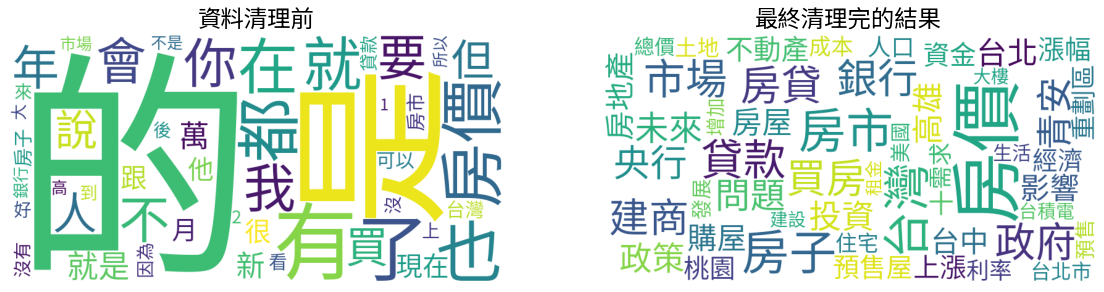

In [37]:
plt.figure(figsize = (14,8))

plt.subplot(1,2,1)
plt.imshow(wordcloud)
plt.axis('off')
plt.title("資料清理前")

plt.subplot(1,2,2)
plt.imshow(wordcloud_after)
plt.axis('off')
plt.title("最終清理完的結果")

plt.show()

儲存clean data，以便後續其他使用

In [38]:
nostop_df_updated.to_csv("raw_data/cleaned_ptt_house_price.csv", encoding = 'utf-8',index = False)

### 3. Lexicon-based 情緒分析

In [39]:
# 讀取情緒字典
liwc_dict = pd.read_csv("./dict/liwc/LIWC_CH.csv")
liwc_dict = liwc_dict.rename(columns={'name': 'word', "class": 'sentiments'})
liwc_dict.head()

,word,sentiments
0,):,affect
1,3q,affect
2,:(,affect
3,:),affect
4,<3,affect


In [40]:
liwc_dict['sentiments'].describe()

count       4682
unique         6
top       affect
freq        2061
Name: sentiments, dtype: object

#### 3.2 情緒字典與斷詞結果進行合併

In [41]:
print(nostop_df_updated.columns)


Index(['artUrl', 'artTitle', 'artDate', 'artContent', 'word'], dtype='object')


In [79]:
nostop_df_updated = pd.read_csv("raw_data/cleaned_ptt_house_price.csv", encoding="utf-8")
print(nostop_df_updated.columns)

# 切割日期與時間
nostop_df_updated["artDate"] = pd.to_datetime(nostop_df_updated["artDate"])  # 轉換為 datetime 格式
nostop_df_updated["artTime"] = nostop_df_updated["artDate"].dt.time  # 取出時間部分
nostop_df_updated["artDate"] = nostop_df_updated["artDate"].dt.date  # 取出日期部分
# 顯示切割後的結果
print(nostop_df_updated[["artDate", "artTime"]].head())

print(nostop_df_updated.columns)
# 存回 CSV
nostop_df_updated.to_csv("raw_data/cleaned_ptt_house_price_updated.csv", encoding="utf-8", index=False)

ptt_liwc_df = pd.merge(nostop_df_updated[["artUrl", "artDate", "artTitle", "artContent", "word"]], liwc_dict, how="left")
ptt_liwc_df.head()

Index(['artUrl', 'artTitle', 'artDate', 'artContent', 'word'], dtype='object')
      artDate   artTime
0  2024-03-01  07:25:58
1  2024-03-01  07:25:58
2  2024-03-01  07:25:58
3  2024-03-01  07:25:58
4  2024-03-01  07:25:58
Index(['artUrl', 'artTitle', 'artDate', 'artContent', 'word', 'artTime'], dtype='object')


,artUrl,artDate,artTitle,artContent,word,sentiments
0,https://www.ptt.cc/bbs/home-sale/M.1709249161....,2024-03-01,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,連結：\nhttps://money.udn.com/money/story/5621/78...,駁斥,affect
1,https://www.ptt.cc/bbs/home-sale/M.1709249161....,2024-03-01,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,連結：\nhttps://money.udn.com/money/story/5621/78...,駁斥,negative
2,https://www.ptt.cc/bbs/home-sale/M.1709249161....,2024-03-01,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,連結：\nhttps://money.udn.com/money/story/5621/78...,駁斥,anger
3,https://www.ptt.cc/bbs/home-sale/M.1709249161....,2024-03-01,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,連結：\nhttps://money.udn.com/money/story/5621/78...,養地,NaN
4,https://www.ptt.cc/bbs/home-sale/M.1709249161....,2024-03-01,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,連結：\nhttps://money.udn.com/money/story/5621/78...,炒房,NaN


#### 3.3 正負向情緒詞彙頻率折線圖圖

In [43]:
sentiment_count = pd.DataFrame(
    ptt_liwc_df.groupby(["artDate", "sentiments"]).size()
).reset_index()

mask = (sentiment_count['sentiments'] == "positive") | (sentiment_count['sentiments'] == "negative") 
sentiment_count = sentiment_count.loc[mask]

sentiment_count = sentiment_count.rename(columns={0: "size"})
sentiment_count = sentiment_count.sort_values(["artDate"])
sentiment_count.head(10)

,artDate,sentiments,size
3,2024-03-01,negative,32
4,2024-03-01,positive,31
8,2024-03-02,negative,9
9,2024-03-02,positive,16
14,2024-03-03,negative,17
15,2024-03-03,positive,19
20,2024-03-04,negative,40
21,2024-03-04,positive,57
26,2024-03-05,negative,43
27,2024-03-05,positive,55


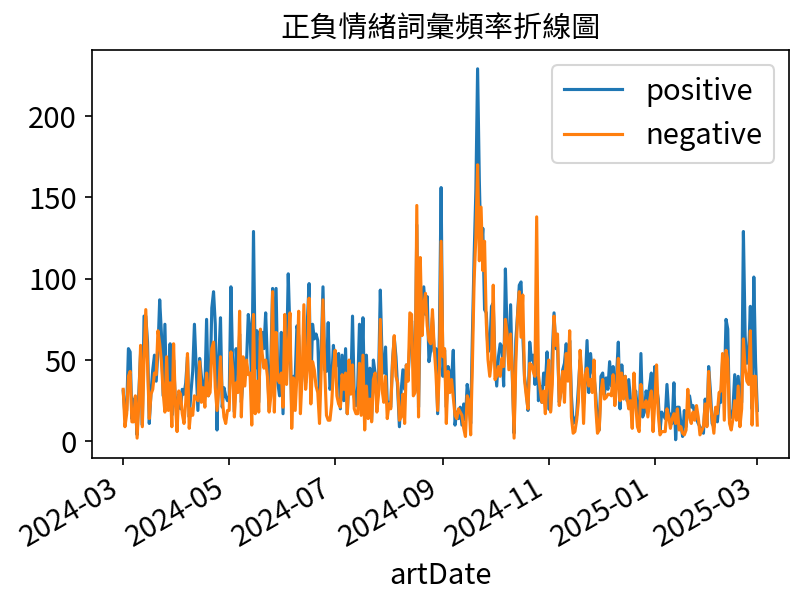

In [80]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
#fig, ax = plt.subplots()

ax.plot(pos["artDate"], pos["size"], color=colors[0])
ax.plot(neg["artDate"], neg["size"], color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒詞彙頻率折線圖", fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

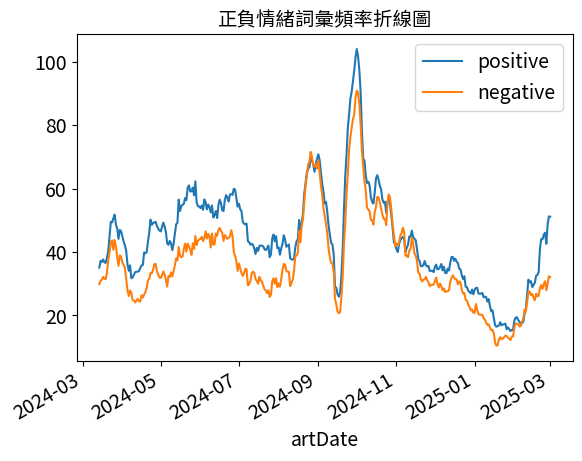

In [45]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 14 天平均
rolling_days = 14
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒詞彙頻率折線圖", fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

#### 3.4 正負向情緒詞彙比例折線圖圖

In [46]:
sentiment_count = sentiment_count.assign(
    ratio=sentiment_count.groupby("artDate")["size"].transform(lambda n: n / n.sum())
)
sentiment_count.head(10)

,artDate,sentiments,size,ratio
3,2024-03-01,negative,32,0.507937
4,2024-03-01,positive,31,0.492063
8,2024-03-02,negative,9,0.360000
9,2024-03-02,positive,16,0.640000
14,2024-03-03,negative,17,0.472222
15,2024-03-03,positive,19,0.527778
20,2024-03-04,negative,40,0.412371
21,2024-03-04,positive,57,0.587629
26,2024-03-05,negative,43,0.438776
27,2024-03-05,positive,55,0.561224


In [47]:
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

Text(0.5, 1.0, '正負情緒比例折線圖')

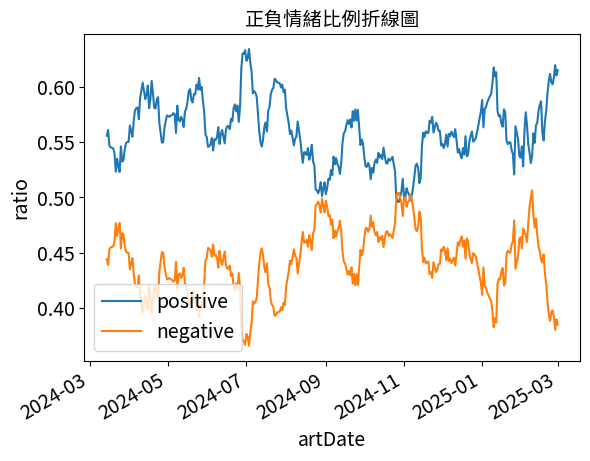

In [48]:
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(pos["artDate"], pos["ratio"].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["ratio"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
plt.ylabel("ratio")
ax.legend(["positive", "negative"], loc="lower left")
fig.autofmt_xdate()
plt.title("正負情緒比例折線圖", fontproperties=fprop)  # 記得加上才能顯示中文

#### 3.5 正負向情緒分數折線圖

In [49]:
sentiment_count.head(10)

,artDate,sentiments,size,ratio
3,2024-03-01,negative,32,0.507937
4,2024-03-01,positive,31,0.492063
8,2024-03-02,negative,9,0.360000
9,2024-03-02,positive,16,0.640000
14,2024-03-03,negative,17,0.472222
15,2024-03-03,positive,19,0.527778
20,2024-03-04,negative,40,0.412371
21,2024-03-04,positive,57,0.587629
26,2024-03-05,negative,43,0.438776
27,2024-03-05,positive,55,0.561224


In [50]:
ptt_sentiment_value = (
    sentiment_count.pivot_table(
        index="artDate", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)
ptt_sentiment_value.head()

,artDate,negative,positive
0,2024-03-01,32.0,31.0
1,2024-03-02,9.0,16.0
2,2024-03-03,17.0,19.0
3,2024-03-04,40.0,57.0
4,2024-03-05,43.0,55.0


In [51]:
# sentiment 計算方式: positive - negative
ptt_sentiment_value["sentiment_value"] = (
    ptt_sentiment_value["positive"]
    - ptt_sentiment_value["negative"]
)
ptt_sentiment_value.head()

,artDate,negative,positive,sentiment_value
0,2024-03-01,32.0,31.0,-1.0
1,2024-03-02,9.0,16.0,7.0
2,2024-03-03,17.0,19.0,2.0
3,2024-03-04,40.0,57.0,17.0
4,2024-03-05,43.0,55.0,12.0


Text(0.5, 1.0, '正負情緒分數趨勢折線圖')

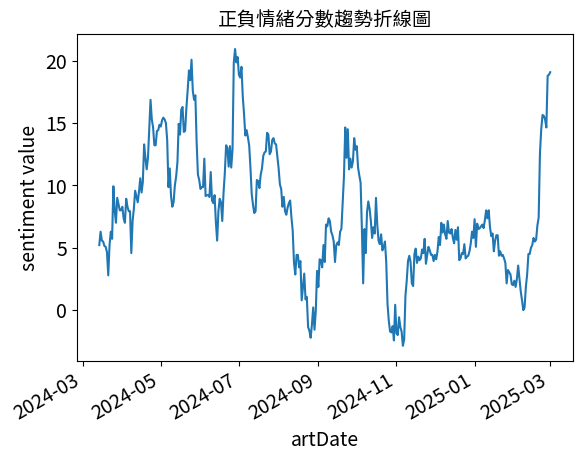

In [52]:
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(ptt_sentiment_value["artDate"], ptt_sentiment_value["sentiment_value"].rolling(rolling_days).mean())
ax.set_xlabel("artDate")
ax.set_ylabel("sentiment value")
fig.autofmt_xdate()
plt.title("正負情緒分數趨勢折線圖", fontproperties=fprop)  # 記得加上才能顯示中文

#### 3.6 文章為單位的情緒分析

In [53]:
sentiment_count_by_article = pd.DataFrame(
    ptt_liwc_df.groupby(["artUrl", "sentiments"]).size()
).reset_index()
sentiment_count_by_article = sentiment_count_by_article.rename(columns={0: "size"})
sentiment_count_by_article.head(10)

,artUrl,sentiments,size
0,https://www.ptt.cc/bbs/home-sale/M.1709249161....,affect,9
1,https://www.ptt.cc/bbs/home-sale/M.1709249161....,anger,2
2,https://www.ptt.cc/bbs/home-sale/M.1709249161....,negative,2
3,https://www.ptt.cc/bbs/home-sale/M.1709249161....,positive,5
4,https://www.ptt.cc/bbs/home-sale/M.1709255830....,affect,1
5,https://www.ptt.cc/bbs/home-sale/M.1709255830....,anx,1
6,https://www.ptt.cc/bbs/home-sale/M.1709255830....,negative,1
7,https://www.ptt.cc/bbs/home-sale/M.1709255830....,sad,1
8,https://www.ptt.cc/bbs/home-sale/M.1709263369....,affect,2
9,https://www.ptt.cc/bbs/home-sale/M.1709263369....,negative,1


In [54]:
ptt_sentiment_value_by_article = (
    sentiment_count_by_article.pivot_table(
        index="artUrl", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)
ptt_sentiment_value_by_article.head()

,artUrl,affect,anger,anx,negative,positive,sad
0,https://www.ptt.cc/bbs/home-sale/M.1709249161....,9.0,2.0,0.0,2.0,5.0,0.0
1,https://www.ptt.cc/bbs/home-sale/M.1709255830....,1.0,0.0,1.0,1.0,0.0,1.0
2,https://www.ptt.cc/bbs/home-sale/M.1709263369....,2.0,0.0,0.0,1.0,1.0,0.0
3,https://www.ptt.cc/bbs/home-sale/M.1709265008....,2.0,0.0,0.0,1.0,1.0,0.0
4,https://www.ptt.cc/bbs/home-sale/M.1709265534....,7.0,0.0,0.0,5.0,5.0,1.0


In [55]:
# sentiment 計算方式: positive - negative
ptt_sentiment_value_by_article["sentiment_value"] = (
    ptt_sentiment_value_by_article["positive"]
    - ptt_sentiment_value_by_article["negative"]
)
ptt_sentiment_value_by_article.head()

,artUrl,affect,anger,anx,negative,positive,sad,sentiment_value
0,https://www.ptt.cc/bbs/home-sale/M.1709249161....,9.0,2.0,0.0,2.0,5.0,0.0,3.0
1,https://www.ptt.cc/bbs/home-sale/M.1709255830....,1.0,0.0,1.0,1.0,0.0,1.0,-1.0
2,https://www.ptt.cc/bbs/home-sale/M.1709263369....,2.0,0.0,0.0,1.0,1.0,0.0,0.0
3,https://www.ptt.cc/bbs/home-sale/M.1709265008....,2.0,0.0,0.0,1.0,1.0,0.0,0.0
4,https://www.ptt.cc/bbs/home-sale/M.1709265534....,7.0,0.0,0.0,5.0,5.0,1.0,0.0


In [56]:
ptt_sentiment_value_by_article['sentiment_class'] = ptt_sentiment_value_by_article['sentiment_value'].apply(lambda x: "正向" if x > 0 else "負向" )
ptt_sentiment_value_by_article.head(10)

,artUrl,affect,anger,anx,negative,positive,sad,sentiment_value,sentiment_class
0,https://www.ptt.cc/bbs/home-sale/M.1709249161....,9.0,2.0,0.0,2.0,5.0,0.0,3.0,正向
1,https://www.ptt.cc/bbs/home-sale/M.1709255830....,1.0,0.0,1.0,1.0,0.0,1.0,-1.0,負向
2,https://www.ptt.cc/bbs/home-sale/M.1709263369....,2.0,0.0,0.0,1.0,1.0,0.0,0.0,負向
3,https://www.ptt.cc/bbs/home-sale/M.1709265008....,2.0,0.0,0.0,1.0,1.0,0.0,0.0,負向
4,https://www.ptt.cc/bbs/home-sale/M.1709265534....,7.0,0.0,0.0,5.0,5.0,1.0,0.0,負向
5,https://www.ptt.cc/bbs/home-sale/M.1709267197....,1.0,0.0,0.0,0.0,1.0,0.0,1.0,正向
6,https://www.ptt.cc/bbs/home-sale/M.1709272677....,24.0,3.0,3.0,12.0,8.0,0.0,-4.0,負向
7,https://www.ptt.cc/bbs/home-sale/M.1709289053....,1.0,0.0,0.0,0.0,1.0,0.0,1.0,正向
8,https://www.ptt.cc/bbs/home-sale/M.1709291599....,10.0,0.0,4.0,6.0,4.0,1.0,-2.0,負向
9,https://www.ptt.cc/bbs/home-sale/M.1709292679....,4.0,0.0,0.0,0.0,4.0,0.0,4.0,正向


In [57]:
clear_df_sentiment = pd.merge(df, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")
clear_df_sentiment["artDate"] = pd.to_datetime(clear_df_sentiment["artDate"])
clear_df_sentiment['artDate'] = clear_df_sentiment['artDate'].dt.date

clear_df_sentiment.head()

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource,sentiment_class
0,1,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01,jump0517,home_sale,連結：\nhttps://money.udn.com/money/story/5621/78...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""fatpigbgman""...",1.168.65.178,2024-03-02 01:42:37,ptt,正向
1,2,https://www.ptt.cc/bbs/home-sale/M.1709251729....,[情報]好房網2月房價,2024-03-01,linlinme5208,home_sale,好房網 重點縣市成交漲跌排行\nhttps://price.housefun.com.tw/...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""ChennBZ"", ""c...",211.20.144.117,2024-03-02 01:42:37,ptt,NaN
2,3,https://www.ptt.cc/bbs/home-sale/M.1709255830....,Re:[情報]好房網2月房價,2024-03-01,junior020486,home_sale,你們那個要買新竹熱區的手腳要快\n新竹現在很誇張\n外圍補漲的很兇\n前幾天星XX超開價成交...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""hellogym"", ""...",49.216.24.218,2024-03-02 01:42:37,ptt,負向
3,4,https://www.ptt.cc/bbs/home-sale/M.1709260904....,[閒聊]基隆是台北之外最不可能蓋GG的嗎,2024-03-01,Austenite,home_sale,最近各縣市都被點名要蓋GG\n高雄 台中 嘉義 虎尾\n被點名出列的房價都開始漲\n\n基隆...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""wwrest"", ""cm...",1.163.246.7,2024-03-02 01:42:37,ptt,NaN
4,5,https://www.ptt.cc/bbs/home-sale/M.1709263369....,[請益]預售屋可否負擔,2024-03-01,mosfets,home_sale,各位前輩好\n\n小弟目前在竹科工作 覺得新竹房價越來越高 因為工作快三年 有些自備款 有想...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""JohnLackey"",...",39.9.32.99,2024-03-02 01:42:37,ptt,負向


In [58]:
sentiment_art_count = pd.DataFrame(
    clear_df_sentiment.groupby(["artDate", "sentiment_class"]).size()
).reset_index()
sentiment_art_count = sentiment_art_count.rename(columns={0: "size"})
sentiment_art_count = sentiment_art_count.sort_values(["artDate"])
sentiment_art_count

,artDate,sentiment_class,size
0,2024-03-01,正向,5
1,2024-03-01,負向,7
2,2024-03-02,正向,2
3,2024-03-02,負向,1
4,2024-03-03,正向,2
...,...,...,...
709,2025-02-27,負向,5
710,2025-02-28,正向,4
711,2025-02-28,負向,8
712,2025-03-01,正向,4


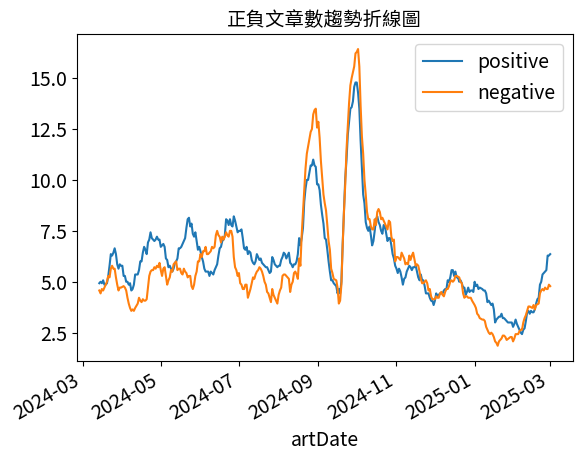

In [59]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_art_count[sentiment_art_count["sentiment_class"] == "正向"]
neg = sentiment_art_count[sentiment_art_count["sentiment_class"] == "負向"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 14 天平均
rolling_days = 14
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])
# ax.plot(pos["artDate"], pos['size'], color=colors[0])
# ax.plot(neg["artDate"], neg["size"], color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負文章數趨勢折線圖", fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

#### 情緒代表字

In [146]:
word_count = ptt_liwc_df.groupby(["word", "sentiments"]).size().reset_index()   
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)

word_count.head(10)

,word,sentiments,size
542,問題,affect,1703
543,問題,negative,1703
2400,負擔,negative,569
2399,負擔,affect,569
853,希望,affect,542
854,希望,positive,542
2634,風險,negative,518
2633,風險,anx,518
2632,風險,affect,518
641,壓力,affect,484


In [147]:
word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]      # 正向的情緒代表字
word_of_pos.head(15)

,word,sentiments,size
854,希望,positive,542
2047,簡單,positive,399
2628,願意,positive,365
505,吸引,positive,355
485,合理,positive,329
800,容易,positive,325
2531,重要,positive,324
561,喜歡,positive,320
1466,有錢,positive,311
186,信義,positive,306


In [174]:
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]      # 負向的情緒代表字
word_of_neg.head(15)

,word,sentiments,size
543,問題,negative,1703
2400,負擔,negative,569
2634,風險,negative,518
643,壓力,negative,484
1350,擔心,negative,307
2565,降低,negative,279
604,嚴重,negative,231
64,不足,negative,220
2303,衝擊,negative,196
2582,隨便,negative,185


/tmp/ipykernel_422312/1493987806.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
/tmp/ipykernel_422312/1493987806.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(neg["word"], fontproperties=fprop)


Text(0.5, 1.0, '負向情緒總數')

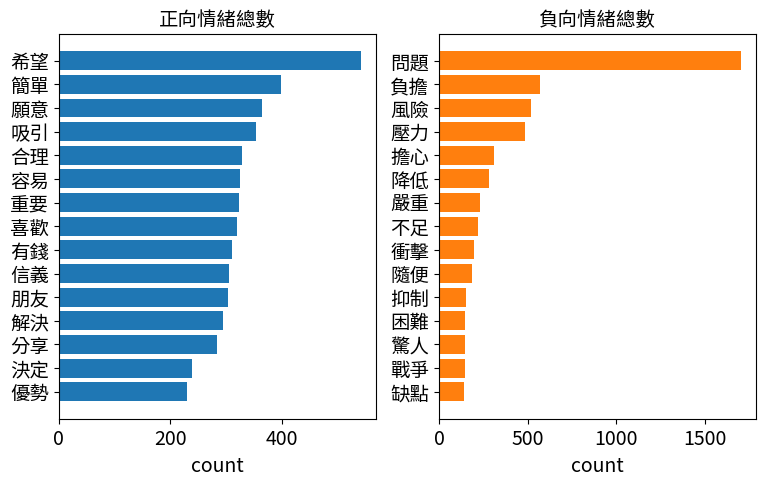

In [175]:
pos = word_of_pos.head(15).sort_values(["size"], ascending=True)
neg = word_of_neg.head(15).sort_values(["size"], ascending=True)

fig, ax = plt.subplots(1, 2, figsize=(9,5))

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
ax[0].set_title("正向情緒總數", fontproperties=fprop)

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"], fontproperties=fprop)
ax[1].set_title("負向情緒總數", fontproperties=fprop)

### 檢查情緒詞是否符合文本 

In [176]:
filtered_df = sent_df[sent_df['sentence'].str.contains('降低', na=False)]  
filtered_df.head()

,artUrl,artTitle,artDate,artContent,sentence,sentiment_class
236,https://www.ptt.cc/bbs/home-sale/M.1709265534....,[新聞]小坪數買氣夯？全台「小宅」驚人空屋率曝,2024-03-01,小坪數買氣夯？全台「小宅」驚人空屋率曝光\n\nTVBS 記者 陳文越 / 攝影 鍾德榮 報...,另一邊的建商也為了降低總價,負向
468,https://www.ptt.cc/bbs/home-sale/M.1709291599....,[請益]台北市購屋規劃請教,2024-03-01,板上各位前輩好，最近在考慮買第一間房子，想請教大家的意見和建議\n\n背景資訊：\n- 年齡...,還是該降低購房預算至3000左右會比較保險,負向
1592,https://www.ptt.cc/bbs/home-sale/M.1709572735....,[新聞]全面「撤辣」首周末香港房市爆了！,2024-03-05,連結：全面「撤辣」 首周末 香港房市爆了！\nhttps://news.cnyes.com/...,大幅降低交易,正向
1929,https://www.ptt.cc/bbs/home-sale/M.1709624526....,[閒聊]房地產流動性夠差了，還課房地合一？,2024-03-05,房地產交易的流動性、市場深度非常差了\n\n還課房地合一稅是要幹嘛？\n\n阻礙民間金融發生...,使金融成本降低才是啊,負向
4057,https://www.ptt.cc/bbs/home-sale/M.1710105952....,Re:[閒聊]違建禁售,2024-03-11,違建是因為台灣不是法治國家\n人民普遍自私自利\n台灣是民粹國家\n法律只是參考用\n\n看...,這些事情背後都是在 降低成本,負向


In [177]:
for sentence in filtered_df['sentence'].to_list():
    print(sentence)
    print("=========================")

另一邊的建商也為了降低總價
 還是該降低購房預算至3000左右會比較保險
大幅降低交易
使金融成本降低才是啊
這些事情背後都是在 降低成本
降低豪宅認定標準
我都已經降低挑選標準了
應將首購族購屋門檻降低到5至10
降低至5至10
再降低購屋門檻
備款降低購屋門檻
您各位覺得降低房仲佣金是否能降低房價
但是有捷運已經大幅降低通勤難度
要降低公設比的話
以降低定存損失速度
降低溢出的量但水盆仍滿
等待降低水位的時間
但降低水位的狀況每個年代時空背景
家戶人口平均數降低
民眾可能降低出遊次數
稍微降低青年購屋壓力
降低痛感
業者當然也希望房價降低
來降低房價
降低自備款 拉長貸款年限
降低推案
要降低負擔率控制房貸違約率
就是延長貸款年限降低貸款利率
不過此後一路降低
更可降低短期內的利息支出
1降低不動產風險
2降低青年首購的負擔率
延長年限降低頭期款優惠政策利率
可以用小孩來當分母讓收入降低
跟為保交樓下降低的工程品質
讓房價遲遲未能降低
但是人口自然增加率出生率降低 也就是少子化 是不會讓房價下來的
建商整合意願降低
想利用房子轉增貸降低壓力
降低月還款
的情況會大大降低
也代表著房價快速飆漲的機率已大幅降低
交屋後出租貼利息降低持有成本就好
月付大幅降低
降低買房意願
漲太多有人降低獲利出場
降低對首購族群的衝擊
將更能進一步降低廣大首購族群的購屋門檻
降低金融風險
可降低民眾每月還
以致推案量降低
提升持有稅降低地價 有什麼好處
讓租屋族降低租金負擔
就能讓我們政府得到結論要降房價上漲速度就要降低貨幣量
你一直降低供給量
降低銀行放款時的呆帳風險
 主事者想透過正常的經濟手段公平非強制有選擇去降低
也就是說 他薪水必須大幅降低 就是全台景氣很差
能夠最大程度降低
但也由於入手門檻降低
但通脹又還沒有到非常明顯的降低
造成資產價值降低的問題
都會降低成交件數
專家會說靠短期買賣才能降低房價
讓購屋者降低每月繳款負擔
可是預算降低房子就會變小
長期來看可能會降低貨幣的購買力
對於空間的需求降低所致而在每戶人口持續下降下
新青安也持續幫助年輕人降低房貸負擔
 4月在那邊嘴房價指數降低那篇  5月怎不敢po文了
一來降低風險 二來案子少賺的輕鬆
6承5 房子貸款因門號有2個 在貸款上是否會降低能貸款成數
是降低了新手的入門門檻
首購族有效降低月負擔
央行可能從第二屋擴

### 重新計算情緒
問題、負擔、風險、壓力、擔心、降低、嚴重、不足、衝擊、隨便、抑制、困難、驚人、戰爭、缺點

In [178]:
# 設定要移除的字詞列表
words_to_remove = ['問題','嚴重','隨便','戰爭','驚人','隨便']
# 使用 ~ 運算子和 isin() 方法過濾掉包含在 words_to_remove 列表中的行
liwc_dict_revise = liwc_dict[~liwc_dict['word'].isin(words_to_remove)]
# 使用更新後的情緒字典 merge
ptt_liwc_df_revise = pd.merge(nostop_df_updated[["artUrl", "artDate", "artTitle", "artContent","word"]], liwc_dict_revise, how="left")
ptt_liwc_df_revise.head()

,artUrl,artDate,artTitle,artContent,word,sentiments
0,https://www.ptt.cc/bbs/home-sale/M.1709249161....,2024-03-01,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,連結：\nhttps://money.udn.com/money/story/5621/78...,駁斥,affect
1,https://www.ptt.cc/bbs/home-sale/M.1709249161....,2024-03-01,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,連結：\nhttps://money.udn.com/money/story/5621/78...,駁斥,negative
2,https://www.ptt.cc/bbs/home-sale/M.1709249161....,2024-03-01,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,連結：\nhttps://money.udn.com/money/story/5621/78...,駁斥,anger
3,https://www.ptt.cc/bbs/home-sale/M.1709249161....,2024-03-01,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,連結：\nhttps://money.udn.com/money/story/5621/78...,養地,NaN
4,https://www.ptt.cc/bbs/home-sale/M.1709249161....,2024-03-01,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,連結：\nhttps://money.udn.com/money/story/5621/78...,炒房,NaN


/tmp/ipykernel_422312/1500806013.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
/tmp/ipykernel_422312/1500806013.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(neg["word"], fontproperties=fprop)


Text(0.5, 1.0, '負向情緒總數')

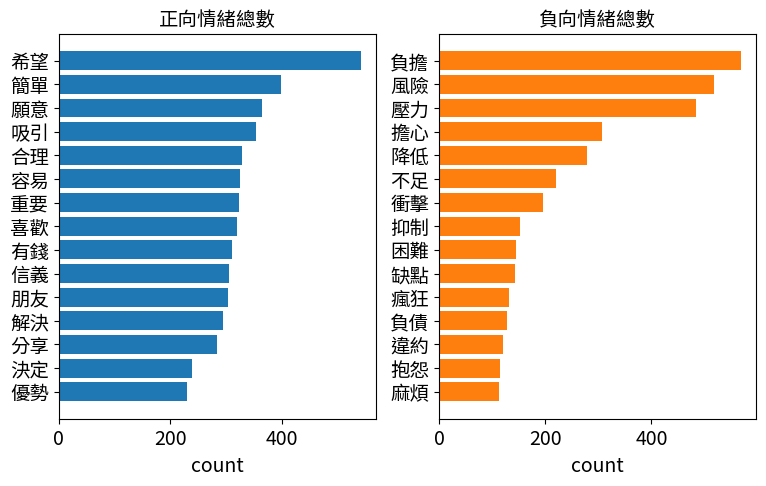

In [179]:
word_count = ptt_liwc_df_revise.groupby(["word", "sentiments"]).size().reset_index()

word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)

word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]

pos = word_of_pos.head(15).sort_values(["size"], ascending=True)
neg = word_of_neg.head(15).sort_values(["size"], ascending=True)

fig, ax = plt.subplots(1, 2, figsize=(9,5))

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
ax[0].set_title("正向情緒總數", fontproperties=fprop)

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"], fontproperties=fprop)
ax[1].set_title("負向情緒總數", fontproperties=fprop)

In [180]:
# 負擔、風險、壓力、擔心、降低、嚴重、不足、衝擊、抑制、困難、瘋狂、負債、違約、抱怨、麻煩、缺點
filtered_df = sent_df[sent_df['sentence'].str.contains('麻煩', na=False)]  
filtered_df.head()

,artUrl,artTitle,artDate,artContent,sentence,sentiment_class
190,https://www.ptt.cc/bbs/home-sale/M.1709265008....,[請益]建議用二胎房貸嗎？,2024-03-01,是這樣的，我目前的房屋是在三年前買的\n\n使用 40 年房貸 / 寬限期 5 年\n\n目...,比較麻煩,負向
427,https://www.ptt.cc/bbs/home-sale/M.1709272677....,[新聞]月收72K想買988萬新成屋 過來人警1事：,2024-03-01,連結：\nhttps://bit.ly/49Ts3Zn\n內文：月收72K想買988萬新成屋...,遇到搬不走的麻煩死了,負向
779,https://www.ptt.cc/bbs/home-sale/M.1709403066....,[請益]竹北高鐵捏緊預售或輕鬆中古,2024-03-03,最近跟女友規劃買房，有想生小孩\n考量環境/學區/上班地點，目標是高鐵西半邊三房平車\n（縣...,再麻煩大家指教了,負向
5029,https://www.ptt.cc/bbs/home-sale/M.1710321232....,Re:[閒聊]股價漲應該高興那房價漲不就更合理？,2024-03-13,你自己不就說了，買不起還可以租，不想花錢租還可以去北車躺有人做伴。\n\n 所以為何一定要買...,麻煩你提出來我再好好回應你,正向
5266,https://www.ptt.cc/bbs/home-sale/M.1710324548....,Re:[閒聊]股價漲應該高興那房價漲不就更合理？,2024-03-13,"剛剛自己說去當街友 科科\n\n房價漲,租金是不是也卯起來漲? 還是你不食人間煙火?\n原來...",麻煩你回答千年房貸,正向


In [181]:
for sentence in filtered_df['sentence'].to_list():
    print(sentence)
    print("=========================")

比較麻煩
遇到搬不走的麻煩死了
再麻煩大家指教了
麻煩你提出來我再好好回應你
麻煩你回答千年房貸
 所以對我們來說徒增麻煩而已
到時候感覺就很麻煩
跨縣市蠻麻煩的
要舉證求償很麻煩
買預售的貸款條件只越來越麻煩
只是台北比較麻煩 因為貧民窟比較多 很難處理
真的是會非常的麻煩
麻煩各位大神們能否給個方向呢
再麻煩各位指教了
 就算你是賺很少他也會找你麻煩
候才驚覺事情麻煩了
公寓比較麻煩
而人與人的問題是很麻煩的
麻煩各位了
這種最麻煩的就是大樓
麻煩的是 嚴重讓經濟市場產生錯置
本來光是應付大寶的進出就已經夠麻煩了
還要跑一些流程和裝潢真的有夠麻煩
搞這些真的很麻煩
對銀行來說跑法拍一定超麻煩
業者怕惹麻煩
N相是最麻煩的
公益出租人真正有一個麻煩問題是
不過這一次比較麻煩的在於
有的話麻煩告知
但領養程序非常麻煩
我越想越覺得麻煩
我把她拉到旁邊請她不用麻煩了
而且怕麻煩又不想碰裝潢
而且家人也覺得裝修很噴錢很麻煩
   有意願一起累積賞屋心得的朋友 麻煩站內信
   麻煩房仲就跳過我吧
雖然翻修是件滿麻煩的事
麻煩你們不要再把台女的問題硬凹成房價的問題
麻煩以後不要再發這種無意義廢文了
你是比較麻煩一點
不然社會局會天天找你麻煩
麻煩看看永和破百萬的頂溪大苑旁10年中古屋現在才賣多少
麻煩看看新板破百萬的勝輝旁10年中古屋現在才賣多少
麻煩摸著自己的良心好嗎
但是對於社會科學就麻煩了
也不會讓自己落入麻煩或是風險當中
應該是不用搞得那麼麻煩
都滿麻煩的
真正麻煩的地方是親戚朋友間借錢
主要的麻煩是貸款額度
很麻煩
這點非常麻煩
光要進出都很麻煩
而房市的麻煩又在於
不過頭期200偏少麻煩跟親戚先預備好再借個200比較保險
在外面找車位比較麻煩
麻煩的是 附近幾乎沒有類似的實價登錄
一堆磚頭水泥 你要打掉很麻煩哩
而目前局面這麼麻煩就在於
才會讓局面這麼麻煩
那我又何必自找麻煩
省了一個大麻煩
籌錢很麻煩
沒有流通性才是最麻煩的
麻煩達人開示分析
到時候繳不起房貸 弄的建商更麻煩
得面臨要搬兩次家的麻煩
那家補習班就麻煩惹
修壁癌漏水不是很麻煩嗎
換屋族先賣後買  中間租房子 搬家很麻煩
換屋族   租房子般家很麻煩
難道廣大貧苦的租屋族    租房子就不麻煩嗎
租屋族被房東驅趕   要強迫搬家時就不麻煩嗎
這就是我們換屋族現在覺得有點麻煩的事情
A7酸酸在那邊

In [170]:
# 設定要移除的字詞列表
words_to_remove = ['麻煩']
# 使用 ~ 運算子和 isin() 方法過濾掉包含在 words_to_remove 列表中的行
liwc_dict_revise = liwc_dict[~liwc_dict['word'].isin(words_to_remove)]
# 使用更新後的情緒字典 merge
ptt_liwc_df_revise = pd.merge(nostop_df_updated[["artUrl", "artDate", "artTitle", "artContent","word"]], liwc_dict_revise, how="left")
ptt_liwc_df_revise.head()

,artUrl,artDate,artTitle,artContent,word,sentiments
0,https://www.ptt.cc/bbs/home-sale/M.1709249161....,2024-03-01,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,連結：\nhttps://money.udn.com/money/story/5621/78...,駁斥,affect
1,https://www.ptt.cc/bbs/home-sale/M.1709249161....,2024-03-01,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,連結：\nhttps://money.udn.com/money/story/5621/78...,駁斥,negative
2,https://www.ptt.cc/bbs/home-sale/M.1709249161....,2024-03-01,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,連結：\nhttps://money.udn.com/money/story/5621/78...,駁斥,anger
3,https://www.ptt.cc/bbs/home-sale/M.1709249161....,2024-03-01,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,連結：\nhttps://money.udn.com/money/story/5621/78...,養地,NaN
4,https://www.ptt.cc/bbs/home-sale/M.1709249161....,2024-03-01,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,連結：\nhttps://money.udn.com/money/story/5621/78...,炒房,NaN


/tmp/ipykernel_422312/1500806013.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
/tmp/ipykernel_422312/1500806013.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(neg["word"], fontproperties=fprop)


Text(0.5, 1.0, '負向情緒總數')

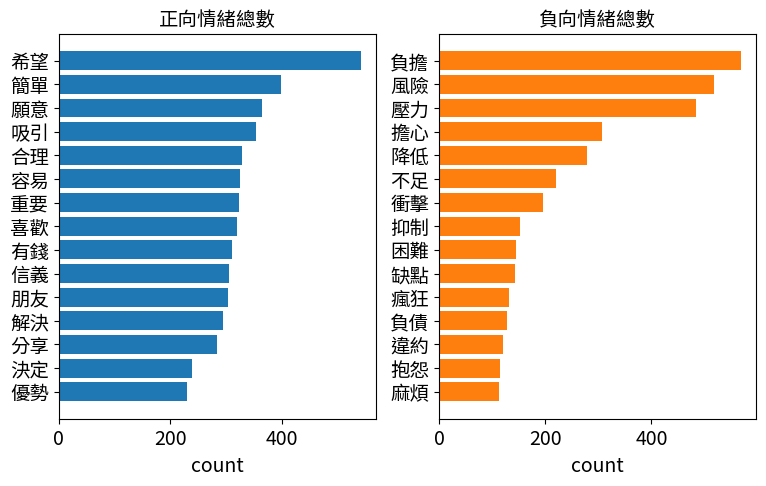

In [182]:
word_count = ptt_liwc_df_revise.groupby(["word", "sentiments"]).size().reset_index()

word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)

word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]

pos = word_of_pos.head(15).sort_values(["size"], ascending=True)
neg = word_of_neg.head(15).sort_values(["size"], ascending=True)

fig, ax = plt.subplots(1, 2, figsize=(9,5))

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
ax[0].set_title("正向情緒總數", fontproperties=fprop)

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"], fontproperties=fprop)
ax[1].set_title("負向情緒總數", fontproperties=fprop)

### 重新繪製情緒分數趨勢圖

Text(0.5, 1.0, '正負情緒分數趨勢折線圖')

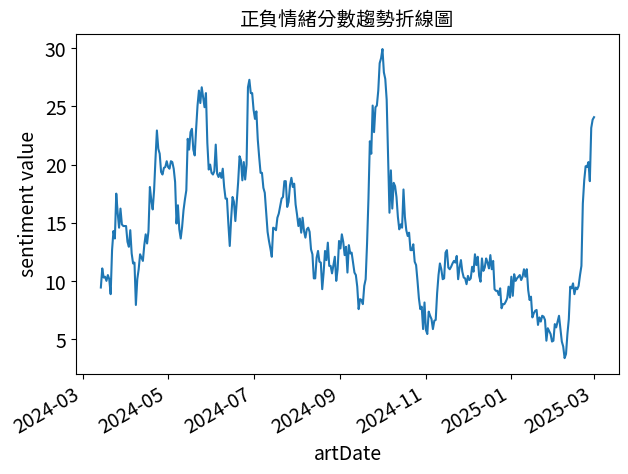

In [183]:
sentiment_count_revise = pd.DataFrame(
    ptt_liwc_df_revise.groupby(["artDate", "sentiments"]).size()
).reset_index()

mask = (sentiment_count_revise['sentiments'] == "positive") | (sentiment_count_revise['sentiments'] == "negative") 
sentiment_count_revise = sentiment_count_revise.loc[mask]

sentiment_count_revise = sentiment_count_revise.rename(columns={0: "size"})
sentiment_count_revise = sentiment_count_revise.sort_values(["artDate"])

ptt_sentiment_value_revise = (
    sentiment_count_revise.pivot_table(
        index="artDate", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)

# sentiment 計算方式: positive - negative
ptt_sentiment_value_revise["sentiment_value"] = (
    ptt_sentiment_value_revise["positive"]
    - ptt_sentiment_value_revise["negative"]
)

# 繪製情緒分數趨勢圖
fig, ax = plt.subplots(figsize=(7,5))

rolling_days = 14
ax.plot(ptt_sentiment_value_revise["artDate"], ptt_sentiment_value_revise["sentiment_value"].rolling(rolling_days).mean())
ax.set_xlabel("artDate")
ax.set_ylabel("sentiment value")
fig.autofmt_xdate()
plt.title("正負情緒分數趨勢折線圖", fontproperties=fprop)

### 3.8 2024-12 ~ 2025-02 文字雲

In [184]:
ptt_liwc_df_revise = pd.merge(ptt_liwc_df_revise, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")
ptt_liwc_df_revise.head()

,artUrl,artDate,artTitle,artContent,word,sentiments,sentiment_class
0,https://www.ptt.cc/bbs/home-sale/M.1709249161....,2024-03-01,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,連結：\nhttps://money.udn.com/money/story/5621/78...,駁斥,affect,正向
1,https://www.ptt.cc/bbs/home-sale/M.1709249161....,2024-03-01,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,連結：\nhttps://money.udn.com/money/story/5621/78...,駁斥,negative,正向
2,https://www.ptt.cc/bbs/home-sale/M.1709249161....,2024-03-01,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,連結：\nhttps://money.udn.com/money/story/5621/78...,駁斥,anger,正向
3,https://www.ptt.cc/bbs/home-sale/M.1709249161....,2024-03-01,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,連結：\nhttps://money.udn.com/money/story/5621/78...,養地,NaN,正向
4,https://www.ptt.cc/bbs/home-sale/M.1709249161....,2024-03-01,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,連結：\nhttps://money.udn.com/money/story/5621/78...,炒房,NaN,正向


In [185]:
sent_df = pd.merge(sent_df, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")
sent_df.head()

,artUrl,artTitle,artDate,artContent,sentence,sentiment_class
0,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01,連結：\nhttps://money.udn.com/money/story/5621/78...,連結,正向
1,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01,連結：\nhttps://money.udn.com/money/story/5621/78...,駁斥養地炒房說,正向
2,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01,連結：\nhttps://money.udn.com/money/story/5621/78...,媒體報導,正向
3,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01,連結：\nhttps://money.udn.com/money/story/5621/78...,具公股色彩的台灣金聯近年大舉在南台灣與建商競標土地,正向
4,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01,連結：\nhttps://money.udn.com/money/story/5621/78...,得標後不開發,正向


In [186]:
date = "2024-12"
end_date = "2025-02"
mask = (ptt_liwc_df_revise['artDate'] >= pd.Timestamp(date).date()) & (
    ptt_liwc_df_revise['artDate'] <= pd.Timestamp(end_date).date()) & (
    ptt_liwc_df_revise['sentiment_class'] == "負向")

ptt_df_wc = ptt_liwc_df_revise.loc[mask]
ptt_df_wc.head(10)

,artUrl,artDate,artTitle,artContent,word,sentiments,sentiment_class
555471,https://www.ptt.cc/bbs/home-sale/M.1733023921....,2024-12-01,[新聞]賣方軟了房市回穩？11月房仲交易量回升4%,https://www.setn.com/News.aspx?NewsID=1572152\...,專家,NaN,負向
555472,https://www.ptt.cc/bbs/home-sale/M.1733023921....,2024-12-01,[新聞]賣方軟了房市回穩？11月房仲交易量回升4%,https://www.setn.com/News.aspx?NewsID=1572152\...,買方,NaN,負向
555473,https://www.ptt.cc/bbs/home-sale/M.1733023921....,2024-12-01,[新聞]賣方軟了房市回穩？11月房仲交易量回升4%,https://www.setn.com/News.aspx?NewsID=1572152\...,市場,NaN,負向
555474,https://www.ptt.cc/bbs/home-sale/M.1733023921....,2024-12-01,[新聞]賣方軟了房市回穩？11月房仲交易量回升4%,https://www.setn.com/News.aspx?NewsID=1572152\...,傾斜,NaN,負向
555475,https://www.ptt.cc/bbs/home-sale/M.1733023921....,2024-12-01,[新聞]賣方軟了房市回穩？11月房仲交易量回升4%,https://www.setn.com/News.aspx?NewsID=1572152\...,銀行,NaN,負向
555476,https://www.ptt.cc/bbs/home-sale/M.1733023921....,2024-12-01,[新聞]賣方軟了房市回穩？11月房仲交易量回升4%,https://www.setn.com/News.aspx?NewsID=1572152\...,房貸,NaN,負向
555477,https://www.ptt.cc/bbs/home-sale/M.1733023921....,2024-12-01,[新聞]賣方軟了房市回穩？11月房仲交易量回升4%,https://www.setn.com/News.aspx?NewsID=1572152\...,吃緊,NaN,負向
555478,https://www.ptt.cc/bbs/home-sale/M.1733023921....,2024-12-01,[新聞]賣方軟了房市回穩？11月房仲交易量回升4%,https://www.setn.com/News.aspx?NewsID=1572152\...,狀況,NaN,負向
555479,https://www.ptt.cc/bbs/home-sale/M.1733023921....,2024-12-01,[新聞]賣方軟了房市回穩？11月房仲交易量回升4%,https://www.setn.com/News.aspx?NewsID=1572152\...,短期,NaN,負向
555480,https://www.ptt.cc/bbs/home-sale/M.1733023921....,2024-12-01,[新聞]賣方軟了房市回穩？11月房仲交易量回升4%,https://www.setn.com/News.aspx?NewsID=1572152\...,難以,NaN,負向


In [187]:
date = "2024-12"
end_date = "2025-02"
mask = (ptt_liwc_df_revise['artDate'] >= pd.Timestamp(date).date()) & (
    ptt_liwc_df_revise['artDate'] <= pd.Timestamp(end_date).date()) & (
    ptt_liwc_df_revise['sentiment_class'] == "負向")

ptt_df_wc = ptt_liwc_df_revise.loc[mask, ["artDate", "word"]]


word_count_count = pd.DataFrame(
    ptt_df_wc.groupby(["word"]).size()
).reset_index().rename(columns={0: "size"})

word_count_count = word_count_count.sort_values(by='size', ascending=False)
word_count_count.head(10)

,word,size
3868,房價,451
2338,台灣,160
3878,房市,152
3874,房子,133
3890,房貸,131
2779,壓力,123
6916,貸款,123
7661,銀行,123
2474,問題,111
3392,市場,100


(-0.5, 1599.5, 799.5, -0.5)

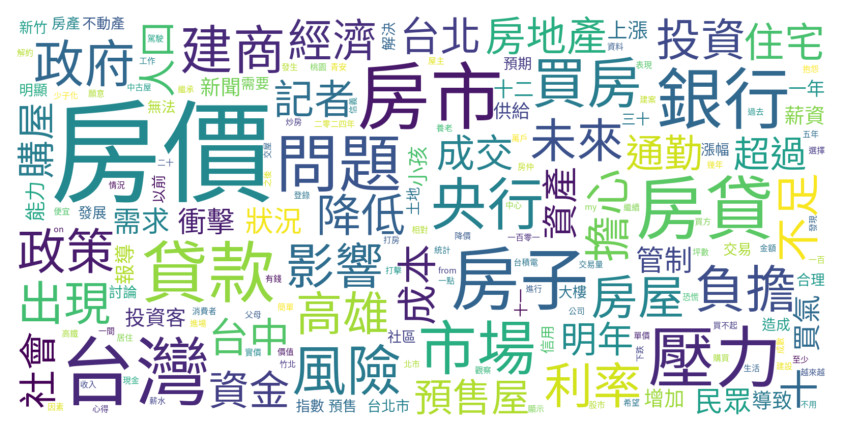

In [188]:
# wordcloud 的 input 是 dictionary
font_path = "./raw_data/SourceHanSansTW-Regular.otf"  # 中文字型路徑
wc_dict = dict(zip(word_count_count['word'], word_count_count['size']))
cloud = WordCloud(scale = 4, max_words=200, background_color="white", font_path=font_path)
cloud.generate_from_frequencies(wc_dict)
# 繪圖
plt.figure(figsize=(7, 4), dpi=150)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
# plt.show()

#### 關鍵字出現了「房價」、「房貸」、「壓力」、「負擔」的關鍵字，可能是在說明買房可能遇到的狀況

(-0.5, 1599.5, 799.5, -0.5)

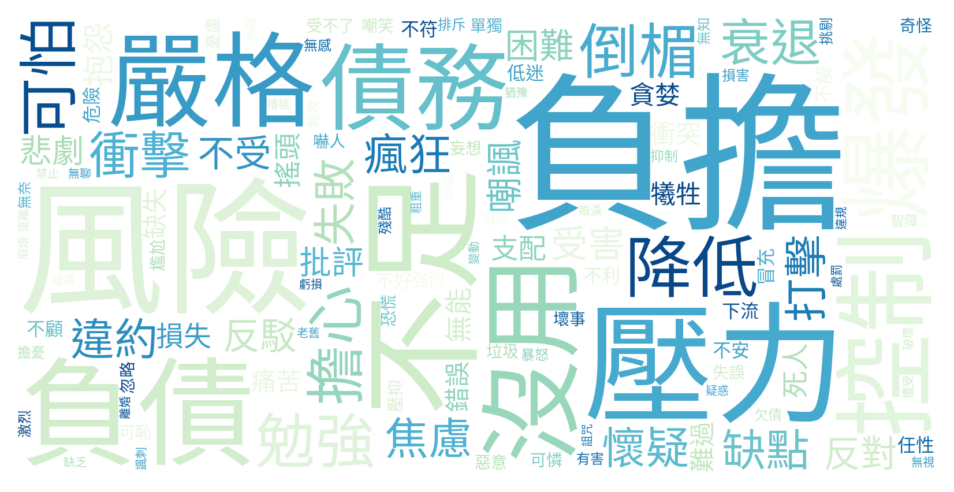

In [ ]:
date = "2024-12"
end_date = "2025-02"
mask = (ptt_liwc_df_revise['artDate'] >= pd.Timestamp(date).date()) & (
    ptt_liwc_df_revise['artDate'] <= pd.Timestamp(end_date).date()) & ( # 時間區間
    ptt_liwc_df_revise['sentiment_class'] == "負向")  & ( # 負面文章
    ptt_liwc_df_revise['artContent'].str.contains('房子')) & ( # 內文包含房子
    ptt_liwc_df_revise["sentiments"] == "negative") # 負面情緒字

ptt_df_wc = ptt_liwc_df_revise.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()

# wordcloud 的 input 是 dictionary
cloud = WordCloud(scale = 4, max_words=200, background_color="white", font_path=font_path, colormap="GnBu")
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(
    cloud, 
    interpolation="bilinear"
)
plt.axis("off")
# plt.show()

#### 用「負擔」去察看原文

In [194]:
date = "2024-12"
end_date = "2025-02"
mask = (sent_df['artDate'] >= pd.Timestamp(date).date()) & (
    sent_df['artDate'] <= pd.Timestamp(end_date).date()) & (
    sent_df['sentiment_class'] == "負向") & (
    sent_df['artContent'].str.contains('房子')) & (
    sent_df['sentence'].str.contains('負擔')) # 包含「負擔」的句子

df_ = sent_df.loc[mask, ["artDate", "artContent", "sentence"]]
index_list = df_.index.tolist()


# 取得前後各5筆的索引 => 目的為查看包含該詞彙句子的上下文
surrounding_indices = []
for index in index_list:
    surrounding_indices.extend(range(index - 5, index + 6))

# 去除重複的索引，並確保不超出範圍
surrounding_indices = list(set(filter(lambda x: x >= 0 and x < len(sent_df), surrounding_indices)))

# 依據索引取得相應的資料
result_df = sent_df.iloc[surrounding_indices].sort_index()
result_df[['artTitle', 'sentence', 'sentiment_class']].head(15)

,artTitle,sentence,sentiment_class
165429,Re:[心得]第一次買房心路歷程,原PO五年還清,負向
165430,Re:[心得]第一次買房心路歷程,意思也就是60個月還了200萬,負向
165431,Re:[心得]第一次買房心路歷程,平均每個月不算利息的話要還三萬多,負向
165432,Re:[心得]第一次買房心路歷程,我數學沒有很好,負向
165433,Re:[心得]第一次買房心路歷程,但當時基本薪資才一萬多,負向
165434,Re:[心得]第一次買房心路歷程,每個月可以負擔三萬多是真的蠻驚人的,負向
165435,Re:[心得]第一次買房心路歷程,我用房貸試算了一下,負向
165436,Re:[心得]第一次買房心路歷程,當時貸款200萬,負向
165437,Re:[心得]第一次買房心路歷程,期間20年,負向
165438,Re:[心得]第一次買房心路歷程,利率5的話,負向


##### 可以看出文章中提到了，買房的人可能短期內需要承擔鉅額還款，以及房貸的條件過於嚴格，造成了買房的財務負擔。